# Phân tích đa biến
BS Vương Kiến Thanh

Các bài trước, chúng ta chỉ tập trung một biến số và một outcome. Tuy nhiên, thực tế còn rất nhiều biến số khác ảnh hưởng đến outcome như tuổi, giới, địa lý,...  
Nếu chúng ta chỉ dùng một biến để hypothesis testing thì nhiều khi chúng ta bỏ sót nhiều mối quan hệ khác.  

Bài này, tôi xin nói về phân tích đa biến như thế nào.




In [1]:
# import các library liên quan
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from causalgraphicalmodels import CausalGraphicalModel
import seaborn as sns
# 1 vài functions
def calc_OR(xtab):
    smtab = sm.stats.Table2x2(xtab)
    print("OR=", smtab.oddsratio,"- Khoảng tin cậy 95%", smtab.oddsratio_confint())

## I. Định nghĩa:  
1. Confounder: là một biến vừa có tác động lên biến số vừa tác động lên outcome.  
    Dùng Stratified tables để tìm confounder.
2. Effect modification: là 1 biến thứ 3 tác động lên outcome, độc lập với biến ban đầu.
3. Interaction: tương tự như tác đụng hiệp động trong được lý, hay 1+1=3

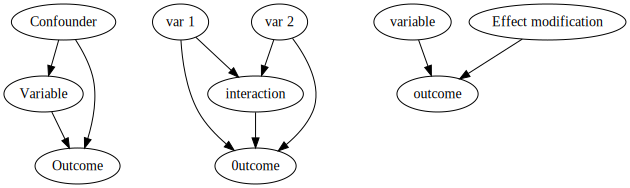

In [4]:
graph = CausalGraphicalModel(
    
    nodes=["Confounder", "Variable", "Outcome", "Effect modification", "variable", "outcome",
           "var 1", "var 2", "interaction", "0utcome"],
    edges=[
        ("Confounder", "Outcome"), 
        ("Confounder", "Variable"), 
        ("Variable", "Outcome"),
        ("Effect modification", "outcome"),
        ("variable", "outcome"),
        ("var 1", "0utcome"),
        ("var 2", "0utcome"),
        ("var 1", "interaction"),
        ("var 2", "interaction"),
        ("interaction", "0utcome")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
graph.draw()

### Ví dụ: dataset framingham heart study, có trên Kaggle

In [3]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# Định nghĩa ai có BMI >=30 là béo phì
df['obese'] = df['BMI']>=30

In [5]:
# Chuyển sang crosstab giữa béo phì và biến chứng CHD sau 10 năm
xtab = pd.crosstab([df['obese'], ], df['TenYearCHD'] )
xtab

TenYearCHD,0,1
obese,,
False,3162,539
True,434,105


In [6]:
# OR về biến chứng CHD sau 10 năm của nhóm béo phì và không béo phì

calc_OR(xtab)

# OR = 1.42
# nguoi beo phi co nguy co CHD 10 nam >1,42 lan nguoi ko beo phi

OR= 1.4192949907235621 - Khoảng tin cậy 95% (1.1255348414115904, 1.7897253790621281)


In [7]:
# giả sử ta cho thêm biến male vào để phân tích
# vì ta nghĩ rằng biến male có thể ảnh hưởng đến outcome CHD
xtab2 = pd.crosstab([df['male'], df['obese'], ], df['TenYearCHD'] )
xtab2

# đây gọi là stratified tables, tức là nhiều table 2x2 dựa các strata

TenYearCHD     0    1
male obese           
0    False  1854  244
     True    265   57
1    False  1308  295
     True    169   48

In [8]:
# tính OR 2 nhóm strata
calc_OR(xtab2.loc[0]) # female
calc_OR(xtab2.loc[1]) # male

# Trong nhóm female, OR cao hơn ( 1.63 so với 1.42)
# Trong nhóm male, OR thấp hơn ( 1.26 so với 1.42), KTC chứa 1

# => Vậy male ảnh hưởng đến TenYearCHD

OR= 1.634364367460563 - Khoảng tin cậy 95% (1.1918321967307675, 2.241210543692144)
OR= 1.2593320629826497 - Khoảng tin cậy 95% (0.8922795570224816, 1.777377092610201)


In [9]:
# Tiếp theo tìm male có ảnh hưởng đến obese ko

xtab3 = pd.crosstab(df['male'], df['obese'])
xtab3

obese,False,True
male,,
0,2098,322
1,1603,217


In [10]:
# Ta dùng chi2 để xem tỉ lệ obese của 2 nhóm của độc lập không
st.chi2_contingency(xtab3)

# hàm trên return ( chi2_stat, p value, degree of freedom, expected value table)
# H0: 2 biến độc lập nhau
# p_val = 0.197, tức là không reject được H0.

(1.6673639823158952,
 0.1966119795975374,
 1,
 array([[2112.36320755,  307.63679245],
        [1588.63679245,  231.36320755]]))

#### Kết luận: biến male là một effect modification.

In [11]:
# ta nghĩ age >50 thì dễ béo phì và dễ mắc CHD
df['age>50'] = df['age']>=50

In [12]:
# Tạo crosstab obese ~ CHD với 2 strata age>=50, age<50
xtab4 = pd.crosstab([df['age>50'],df['obese']],df['TenYearCHD'])
xtab4

TenYearCHD       0    1
age>50 obese           
False  False  1812  162
       True    215   28
True   False  1350  377
       True    219   77

In [13]:
# tính OR 2 strata
calc_OR(xtab4.loc[0]) # age <50
calc_OR(xtab4.loc[1]) # age >50

# Trong nhóm age<50, OR=1.46 tương đồng OR chung=1.42
# Trong nhóm age>50, OR=1.25 thấp hơn so với 1.42

# => Vậy age>50 cũng có effect lên TenYearCHD, nhưng không bao nhiêu


OR= 1.4566752799310938 - Khoảng tin cậy 95% (0.9520280221073252, 2.2288239651449278)
OR= 1.259038552378184 - Khoảng tin cậy 95% (0.9480810799326422, 1.6719857720261389)


In [14]:
# Tiếp theo tìm eff của age>50 lên obese
xtab5 = pd.crosstab(df['age>50'], df['obese'])
xtab5

obese,False,True
age>50,,
False,1974,243
True,1727,296


In [15]:
# dùng chi2 để xem age>50 và obese có độc lập ko?
st.chi2_contingency(xtab5)

# p-val = 0.0004 < 0.05
# vậy reject H0
# age>50 có liên quan với obese

(12.517744736047066,
 0.00040310516891575753,
 1,
 array([[1935.16910377,  281.83089623],
        [1765.83089623,  257.16910377]]))

#### Age>50 có liên quan với obese và liên quan với TenYearCHD
#### Vậy Age>50 là 1 confounder.

## II. Phương pháp COCHRAN–MANTEL-HAENSZEL trong stratified analysis

Nói dễ hiểu là thay vì tính OR chung thì ta tính OR riêng của từng strata rồi tính weighted mean ( trung bình có tỉ trọng).  
Kết quả đó gọi là pooled odds ratio, nó phản ánh chính xác hơn so với khi chưa stratified.

### Ví dụ: data như trên

In [16]:
# statsmodels có sẵn module về stratifiedtable và nó dùng pp COCHRAN–MANTEL-HAENSZEL

stratified = sm.stats.StratifiedTable.from_data(var1='obese',
                                                var2='TenYearCHD',
                                                strata='age>50',
                                                data=df)
stratified.summary()

# pooled odds ratio = 1.314 khoảng tin cậy 95% từ 1.037 ~ 1.664
# so với OR chung là 1.42 KTC 1.13 ~ 1.79

,Estimate,LCB,UCB
Pooled odds,1.314,1.037,1.664
Pooled log odds,0.273,0.037,0.510
Pooled risk ratio,1.047,,
,,,
,Statistic,P-value,
Test of OR=1,5.166,0.023,
Test constant OR,0.313,0.576,
,,,
Number of tables,2,,
Min n,2023,,


## III. Correlation analysis

*Correlation analysis* dùng để định lượng mối quan hệ giữa 2 biến với nhau.  
Cụ thể là tìm hệ số tương quan bằng pp của PEARSON.  
Hệ số này có range từ ( -1 , 1) ~ ( tương quan ngược chiều, tương quan cùng chiều)  
Hệ số càng lớn thì tương quan càng lớn.  

Một pp khác là SPEARMAN, là kiểu tính corr dựa trên xếp hạng ( non-parametric )  
PP này sẽ làm mất thông tin của biến nên ít sử dụng.  
Sự khác biệt giữa kết quả PEARSON và SPEARMAN không nhiều.  
Thường được dùng khi data có nhiều outliers.

### Ví dụ: Dataset như trên  
Xem tương quan giữa huyết áp tâm thu và huyết áp tâm trương

In [36]:
df[['sysBP', 'diaBP']].corr()
# corr = 0.78 => Tương quan cùng chiều và lớn

,sysBP,diaBP
sysBP,1.000000,0.783952
diaBP,0.783952,1.000000


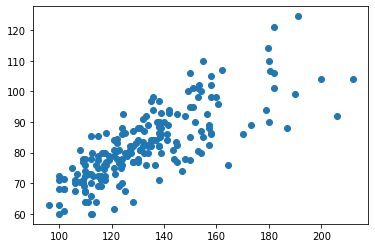

In [37]:
# scatterplot để visualize correlation
# 200 data points đầu tiên
plt.scatter(df['sysBP'][:200], df['diaBP'][:200]);

In [38]:
# Tương quan giữa học thức và hút thuốc lá
df[['education','currentSmoker']].corr()
# corr = 0.018, chắc không liên quan

,education,currentSmoker
education,1.000000,0.018528
currentSmoker,0.018528,1.000000


In [39]:
# Dùng spearman để tính corr
df[['education','currentSmoker']].corr(method='spearman')
# không khác pearson nhiều

,education,currentSmoker
education,1.000000,0.025432
currentSmoker,0.025432,1.000000


In [43]:
# ma trận corr, xin đừng đọc
corr_df = df.corr()
corr_df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,obese,age>50
male,1.000000,-0.029014,0.017415,0.197026,0.317143,-0.052504,-0.004550,0.005853,0.015693,-0.070413,-0.035879,0.058199,0.081871,-0.116932,0.005979,0.088374,-0.020546,-0.021334
age,-0.029014,1.000000,-0.166356,-0.213662,-0.192959,0.123052,0.057679,0.306799,0.101314,0.262554,0.394053,0.205586,0.136096,-0.012843,0.122356,0.225408,0.069405,0.855720
education,0.017415,-0.166356,1.000000,0.018528,0.008323,-0.010898,-0.035142,-0.081726,-0.038749,-0.023613,-0.129496,-0.061919,-0.137747,-0.054182,-0.035843,-0.054248,-0.104141,-0.143691
currentSmoker,0.197026,-0.213662,0.018528,1.000000,0.769774,-0.048927,-0.032980,-0.103710,-0.044285,-0.046488,-0.130281,-0.107933,-0.167857,0.062686,-0.056726,0.019448,-0.109499,-0.203597
cigsPerDay,0.317143,-0.192959,0.008323,0.769774,1.000000,-0.046155,-0.032711,-0.066645,-0.037089,-0.026479,-0.088797,-0.056715,-0.093293,0.075564,-0.058886,0.057755,-0.059924,-0.176193
BPMeds,-0.052504,0.123052,-0.010898,-0.048927,-0.046155,1.000000,0.117370,0.261067,0.052060,0.080623,0.254194,0.194122,0.100702,0.015230,0.051197,0.087519,0.077367,0.096361
prevalentStroke,-0.004550,0.057679,-0.035142,-0.032980,-0.032711,0.117370,1.000000,0.074791,0.006955,0.000105,0.057000,0.045153,0.025909,-0.017674,0.018440,0.061823,0.016849,0.055952
prevalentHyp,0.005853,0.306799,-0.081726,-0.103710,-0.066645,0.261067,0.074791,1.000000,0.077752,0.163632,0.696656,0.615840,0.301344,0.146815,0.086656,0.177458,0.222743,0.269012
diabetes,0.015693,0.101314,-0.038749,-0.044285,-0.037089,0.052060,0.006955,0.077752,1.000000,0.040348,0.111265,0.050260,0.087068,0.048986,0.617630,0.097344,0.067749,0.086506
totChol,-0.070413,0.262554,-0.023613,-0.046488,-0.026479,0.080623,0.000105,0.163632,0.040348,1.000000,0.208734,0.164698,0.115992,0.091127,0.046538,0.082369,0.043708,0.245867


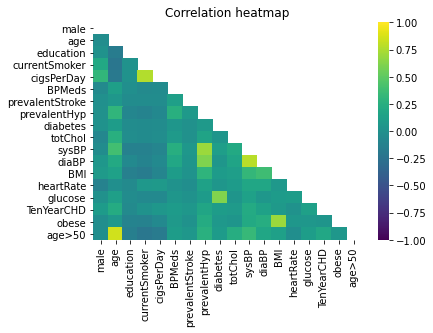

In [46]:
# ma trận corr đọc khùng luôn, color-coded để hấp dẫn hơn
mask_ = np.triu(np.ones_like(corr_df, dtype=np.bool))
sns.heatmap(corr_df,  cmap='viridis', vmin=-1, vmax=1,
           mask=mask_);
plt.title("Correlation heatmap");

### Nhìn chung không có corr âm, chỉ có corr dương ở vài cặp như huyết áp, hút thuốc, đái tháo đường

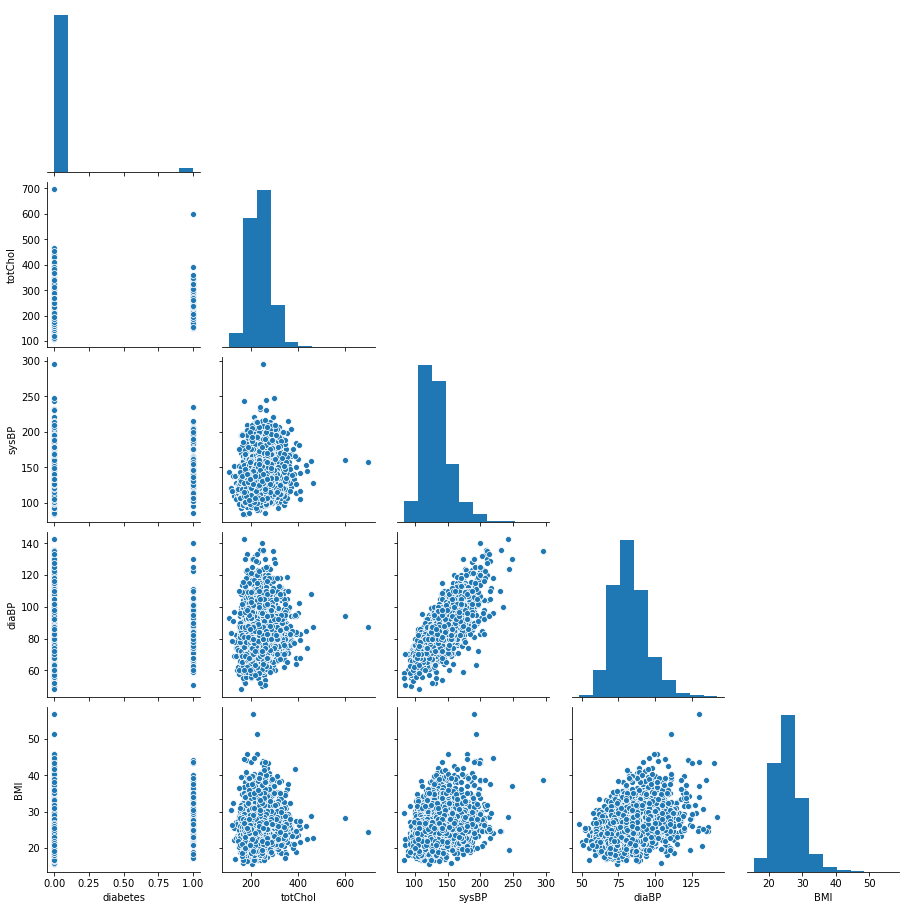

In [23]:
# histogram và scatter_plot cho từng cặp variable. 
# Ở đây plot cho 5 cột giữa
sns.pairplot(df.iloc[:, 8:13], corner=True)

### III. Regression analysis - hồi quy tuyến tính

Phương trình hồi quy tuyến tính đơn giản có dạng:  
( Simple linear Regression )  
$$ \hat{y} = \beta_0 + \beta_1x $$
- $\beta_0$: intercept, là giá trị $\hat{y}$ khi x=0
- $\beta_1$: slope, khi x tăng 1 đơn vị thì y tăng \*slope\* đơn vị

Để tìm ra $\beta_0$ và $\beta_1$, pp thông dụng nhất là least square error
- Đầu tiên, ta định nghĩa cost function là square error.
- Mục tiêu là làm cho square error nhỏ nhất.
- Có thể dùng gradient descent (machine learning)  hoặc normal equation(đạo hàm).

Vì có công thức nên ta có thể tính được giá trị y khi cho một x bất kỳ.  
- x còn gọi là predictor, regressor, independant variable, 
- y còn gọi là dependant variable

### Ví dụ: Tính diaBP dựa trên sysBP trên dataset như trên

In [24]:
# predictor là diaBP, ta thêm một cột intercept là 1
# exog là cách gọi x trong statsmodels
exog = sm.add_constant(df['sysBP'])
exog.head()
# const dùng để đại diện intercept

,const,sysBP
0,1.0,106.0
1,1.0,121.0
2,1.0,127.5
3,1.0,150.0
4,1.0,130.0


In [25]:
# endog là cách gọi y^ trong statsmodels
endog = df['diaBP']
endog.head()

0    70.0
1    81.0
2    80.0
3    95.0
4    84.0
Name: diaBP, dtype: float64

In [26]:
# OLS aka Ordinary least square 
model = sm.OLS(endog=endog, exog=exog).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  diaBP   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     6758.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:36:25   Log-Likelihood:                -14499.
No. Observations:                4240   AIC:                         2.900e+04
Df Residuals:                    4238   BIC:                         2.901e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8091      0.692     38.759      0.000      25.453      28.165
sysBP          0.4238      0.005     82.206      0.000       0.414       0.434
==============================================================================
Omnibus:                      237.742   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              517.056
Skew:                          -0.369   Prob(JB):                    5.28e-113
Kurtosis:                       4.544   Cond. No.                         817.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Hệ số có ở bảng 2
# ở đây hệ số của intercept ( const) = 26.81, tức là khi sys=0, dia=26 @@
# hệ số slope của x là 0.42
# p-value của cả 2 đều rất nhỏ, tức là H_0(hệ số = 0) bị rejected.

# dự đoán một giá trị x bất kỳ
x_pred = np.random.randint(80, 200, size=10)
y_pred = model.predict(sm.add_constant(x_pred) )
for sys,dia in zip(x_pred, y_pred):
    print('sys=', sys, '=> dia=', int(dia))

sys= 170 => dia= 98
sys= 153 => dia= 91
sys= 161 => dia= 95
sys= 82 => dia= 61
sys= 149 => dia= 89
sys= 167 => dia= 97
sys= 193 => dia= 108
sys= 178 => dia= 102
sys= 90 => dia= 64
sys= 170 => dia= 98


### Ví dụ 2: Tính totChol dựa trên BMI

In [29]:
model2 = sm.OLS(endog=df['totChol'],
                exog=sm.add_constant(df['BMI']),
                missing='drop').fit()

In [30]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                totChol   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     56.87
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           5.68e-14
Time:                        16:36:25   Log-Likelihood:                -21735.
No. Observations:                4172   AIC:                         4.347e+04
Df Residuals:                    4170   BIC:                         4.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        204.0295      4.393     46.442      0.000     195.416     212.643
BMI            1.2686      0.168      7.541      0.000       0.939       1.598
==============================================================================
Omnibus:                      834.517   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3795.889
Skew:                           0.900   Prob(JB):                         0.00
Kurtosis:                       7.313   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

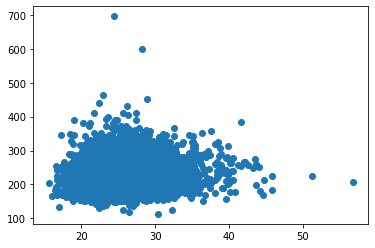

In [31]:
plt.scatter(df['BMI'], df['totChol'])

In [32]:
model2.predict((1,26)) # BMI=26

array([237.01403113])

### Để Regression models predict tốt, thì trước tiên ta check tính linear của x và y bằng scatter plot.
### Tôi muốn nhấn mạnh vấn đề visualization.
Như trong trường hợp totChol ~ BMI thì 2 biến này nhìn trên hình ko mang tính linear nhiều, Trong khi diaBP ~ sysBP thì linear quá rõ ràng.  
R-square có range từ 0 đến 1.  
R-square càng cao thì model càng tốt.  
Model totChol ~ BMI chỉ có R2=0.013. => model không thích hợp để sử dụng.  
Model diaBP ~ sysBP có R2=0.6 => model sẽ hoạt động tốt.

## IV. Các thể loại regression khác

1. Multiple linear regression
$$ \hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... \beta_kx_k$$
2. Polynomial regression
$$ \hat{y} = \beta_0 + \beta_1x_1 + \beta_{21}x_2 + \color{red}{\beta_{22}x_2^2} + ... $$

Hai models trên cũng dùng least square error để tìm hệ số.

3. Logistic regression  
Khi biến y là một biến nhị phân ( 0 hoặc 1 ) thì logistic regression được dùng để xây dựng model dự đoán (0,1) với xác suất p.  
PP là maximum likelihood.  
$$ \text{logit} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... \beta_kx_k$$
$$ \text{Từ logit suy ngược lại p bằng hàm sigmoid}$$  



### Đây là một mảng rất lớn và phức tạp, là cốt lõi nền công nghiệp 4.0, anh chị có tìm hiểu thêm qua các kênh khác.